#### Libraries

In [51]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/albayerga/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [26]:
pip install emoji

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 586.9/586.9 kB 2.5 MB/s eta 0:00:00a 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [27]:
from collections import defaultdict
from array import array
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
import math
import numpy as np
import pandas as pd
import collections
from numpy import linalg as la
import matplotlib.pyplot as plt
import emoji

#### Load data into memory


1 way

In [11]:
docs_path = 'data/farmers-protest-tweets.json'
with open(docs_path) as fp:
    tweets = fp.readlines()
tweets = [l.strip().replace(' +', ' ') for l in tweets]

In [17]:
print("Total number of farmer tweets of 2021 in the corpus: {}".format(len(tweets)))

Total number of farmer tweets of 2021 in the corpus: 117407


In [18]:
print(tweets[0])

{"url": "https://twitter.com/ArjunSinghPanam/status/1364506249291784198", "date": "2021-02-24T09:23:35+00:00", "content": "The world progresses while the Indian police and Govt are still trying to take India back to the horrific past through its tyranny. \n\n@narendramodi @DelhiPolice Shame on you. \n\n#ModiDontSellFarmers \n#FarmersProtest \n#FreeNodeepKaur https://t.co/es3kn0IQAF", "renderedContent": "The world progresses while the Indian police and Govt are still trying to take India back to the horrific past through its tyranny. \n\n@narendramodi @DelhiPolice Shame on you. \n\n#ModiDontSellFarmers \n#FarmersProtest \n#FreeNodeepKaur twitter.com/ravisinghka/st\u2026", "id": 1364506249291784198, "user": {"username": "ArjunSinghPanam", "displayname": "Arjun Singh Panam", "id": 45091142, "description": "Global Citizen, Actor, Director: Sky is the roof above my head, the world is the road I travel, love is my food & mother earth is my bed. Roy in @CosmosMovie", "rawDescription": "Global

2 way

In [12]:
data_tweets = pd.read_json(docs_path, lines=True)
print(data_tweets.head())

                                                 url  \
0  https://twitter.com/ArjunSinghPanam/status/136...   
1  https://twitter.com/PrdeepNain/status/13645062...   
2  https://twitter.com/parmarmaninder/status/1364...   
3  https://twitter.com/anmoldhaliwal/status/13645...   
4  https://twitter.com/KotiaPreet/status/13645061...   

                       date  \
0 2021-02-24 09:23:35+00:00   
1 2021-02-24 09:23:32+00:00   
2 2021-02-24 09:23:22+00:00   
3 2021-02-24 09:23:16+00:00   
4 2021-02-24 09:23:10+00:00   

                                             content  \
0  The world progresses while the Indian police a...   
1  #FarmersProtest \n#ModiIgnoringFarmersDeaths \...   
2  ਪੈਟਰੋਲ ਦੀਆਂ ਕੀਮਤਾਂ ਨੂੰ ਮੱਦੇਨਜ਼ਰ ਰੱਖਦੇ ਹੋਏ \nਮੇ...   
3  @ReallySwara @rohini_sgh watch full video here...   
4  #KisanEktaMorcha #FarmersProtest #NoFarmersNoF...   

                                     renderedContent                   id  \
0  The world progresses while the Indian police a...  13645062

#### Extraer campos Tweet | Date | Hashtags| Likes | Retweets | Url


In [15]:
data_tweets= data_tweets[['content', 'date', 'likeCount', 'retweetCount', 'url']]
data_tweets.head()

,content,date,likeCount,retweetCount,url
0,The world progresses while the Indian police a...,2021-02-24 09:23:35+00:00,0,0,https://twitter.com/ArjunSinghPanam/status/136...
1,#FarmersProtest \n#ModiIgnoringFarmersDeaths \...,2021-02-24 09:23:32+00:00,0,0,https://twitter.com/PrdeepNain/status/13645062...
2,ਪੈਟਰੋਲ ਦੀਆਂ ਕੀਮਤਾਂ ਨੂੰ ਮੱਦੇਨਜ਼ਰ ਰੱਖਦੇ ਹੋਏ \nਮੇ...,2021-02-24 09:23:22+00:00,0,0,https://twitter.com/parmarmaninder/status/1364...
3,@ReallySwara @rohini_sgh watch full video here...,2021-02-24 09:23:16+00:00,0,0,https://twitter.com/anmoldhaliwal/status/13645...
4,#KisanEktaMorcha #FarmersProtest #NoFarmersNoF...,2021-02-24 09:23:10+00:00,0,0,https://twitter.com/KotiaPreet/status/13645061...


In [18]:
for i in range(1):
    print(data_tweets.iloc[i]['content'])

The world progresses while the Indian police and Govt are still trying to take India back to the horrific past through its tyranny. 

@narendramodi @DelhiPolice Shame on you. 

#ModiDontSellFarmers 
#FarmersProtest 
#FreeNodeepKaur https://t.co/es3kn0IQAF


#### 1. Pre-process document

In [28]:
import string
def build_terms(line):

    stemmer = PorterStemmer()
    stop_words = set(stopwords.words("english")) #the""is""in""and""to" , "change to different languages??"

    line = line.lower()  # everything to lowercase
    line = emoji.replace_emoji(line, replace='')  # remove emojis
    translator = str.maketrans('', '', string.punctuation)
    line = line.translate(translator)  # remove punctuation

    line= line.split() # tokenize the text, get a list of terms
    line= [word for word in line if word not in stop_words] # remove stop_words
    line= [stemmer.stem(word) for word in line ] # steam

    return line

In [30]:
terms = build_terms("hello my #name is @john. I am a student, #student 😀")
print(terms)

['hello', 'name', 'john', 'student', 'student']


In [31]:
def preprocess_document(lines):
    preprocessed_tweets = []
    for i in range(len(lines)):
       twt_content = lines.iloc[i]['content']
       content_processed = build_terms(twt_content)
       preprocessed_tweets.append(content_processed)
    return preprocessed_tweets

In [ ]:
processed_tweets = preprocess_document(data_tweets)

#### 2. Exploratory data analysis

Word counting distribution

In [32]:
def word_count_distribution(processed_tweets):
    all_words = [word for tweet in processed_tweets for word in tweet]
    word_count = collections.Counter(all_words)
    most_common_words = word_count.most_common(10)

    words, counts = zip(*most_common_words)
    plt.bar(words, counts)
    plt.xticks(rotation=90)
    plt.show()

/Users/albayerga/Library/Python/3.11/lib/python/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 2325 (\N{DEVANAGARI LETTER KA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/albayerga/Library/Python/3.11/lib/python/site-packages/IPython/core/pylabtools.py:152: UserWarning: Matplotlib currently does not support Devanagari natively.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/albayerga/Library/Python/3.11/lib/python/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 2375 (\N{DEVANAGARI VOWEL SIGN E}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/albayerga/Library/Python/3.11/lib/python/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 2361 (\N{DEVANAGARI LETTER HA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/albayerga/Library/Python/3.11/lib/python/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 2376 (\N{DEVA

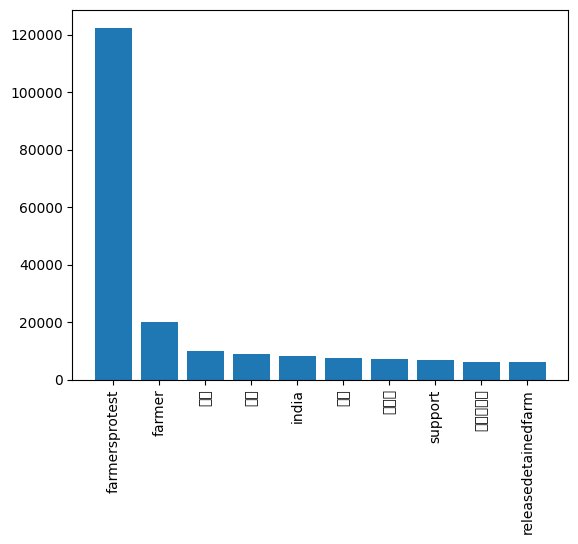

In [33]:
word_count_distribution(processed_tweets)

Average Sentence Length

In [36]:
def average_sentence_length(processed_tweets):
    lengths = [len(tweet) for tweet in processed_tweets]
    return sum(lengths) / len(lengths) if lengths else 0

In [37]:
average_sentence_length(processed_tweets)

13.76950267019854

Vocabulary size

In [39]:
def vocabulary_size(processed_terms):
    all_words = [word for tweet in processed_terms for word in tweet]
    return len(set(all_words))

In [40]:
vocabulary_size(processed_tweets)

189181

Ranking of the most retweeted tweets

In [43]:
def top_retweeted_tweets(data_tweets):
    # to do
    return

Word Clouds for the Most Frequent Words

In [44]:
def generate_word_clouds(processed_tweets):
    # to do
    return

Entity Recognition

In [45]:
def entity_recognition(lines):
    # to do
    return